# How-To: Use Deep Learning models with eo-learn
This notebook shows how deep learning algorithms can be used inside an eo-learn workflow to perform a crop type identification task.

## Before you start
### Requirements

* This notebook doesn't describe how to train a neural network but rather how it is possible to integrate an already trained one inside a workflow to perform some kind of processing. This exemple uses a RefineNet[1] model that was trained to produce semantic segmentation of crop type from Sentinel-2 images.


* In order to run the example you’ll need a configured Sentinel Hub account (see the [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) if necessary)


* This neural network was trained using the [Keras](https://keras.io/) framework version 2.1.3 with [tensorflow](https://www.tensorflow.org/) version 1.4.1 and need to be installed. You can do so by using: 
``` shell
pip install keras==2.1.3
pip install tensorflow==1.4.1
pip install tensorflow-gpu==1.4.1 #for GPU support
``` 

### Overview
This notebook is divided in 2 sections:
 1. Defining the required EO-task 
 2. Visualizing the results

[1]: Lin, G., Milan, A., Shen, C., & Reid, I. (2017, juillet). RefineNet: Multi-path Refinement Networks for High-Resolution Semantic Segmentation. 5168‑5177. https://doi.org/10.1109/CVPR.2017.549

## Defining the required EO-task

For this task we will use a shapefile containing all the crop fields in Austria during 2016 as an exemple:

In [1]:
import geopandas as gpd

austria_lpis_2016 = gpd.read_file('./INSPIRE_SCHLAEGE_POLY_2016_reproj.shp')
austria_lpis_2016.head()

,FS_KENNUNG,SNAR_BEZEI,SL_FLAECHE,KG_NR,KG_NAME,geometry
0,56237696.0,KRNERMAIS,2.405292,66002.0,Arnfels,"POLYGON ((15.40109226383048 46.6807966596994, ..."
1,56237701.0,GRNBRACHE,1.168324,63262.0,Oberpremsttten,"POLYGON ((15.39290467557251 46.97952180785489,..."
2,56237705.0,KRNERMAIS,0.764013,66036.0,Saggau,"POLYGON ((15.3950022566063 46.6879047357612, 1..."
3,56237710.0,KRNERMAIS,2.684438,66002.0,Arnfels,"POLYGON ((15.39507894085918 46.68042360666715,..."
4,56237716.0,KRNERMAIS,2.355382,66016.0,Kitzelsdorf,"POLYGON ((15.39239116140408 46.67917854817072,..."


Each entry from the shapefile contains a polygon defining a field in Austria with its crop type within the **SNAR_BEZEI** field.

We want to see if our model can predict the correct crop type of these field based on Sentinel-2 data. We need some EO-Task that extracts location information from the polygon:

In [2]:
from eolearn.core import EOPatch, FeatureType, EOTask
from sentinelhub.areas import BBox
from sentinelhub.constants import CRS

class InitEOPatch(EOTask):
    def __init__(self, time_interval):
        # Time interval for the Sentinel-2 data
        self.time_interval = time_interval
    
    def execute(self, polygon):
        geometry = polygon.buffer(0.005)
        
        # Get Bounding box of the polygon
        envelope = geometry.envelope.geometry[geometry.envelope.geometry.keys().tolist()[0]]
        bbox = BBox(envelope, crs=CRS.WGS84)
        
        # Store the data inside the EOPatch
        eopatch = EOPatch()
        eopatch.vector_timeless['polygon'] = polygon
#         eopatch.vector_timeless['polygon'] = gpd.GeoDataFrame(polygon, crs={'init' :'WGS84'})
        eopatch.meta_info['time_interval'] = self.time_interval
        eopatch.bbox = bbox
        return eopatch

# Initialise the task for data taken suring the 2016 summer
init_task = InitEOPatch(('2016-05-01', '2016-08-31'))

#Display an example from one polygon:
example_patch = init_task.execute(austria_lpis_2016[0:1])
display(example_patch)

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    time_interval: ('2016-05-01', '2016-08-31')
  }
  bbox: BBox(((15.392993871155127, 46.674385824822146), (15.406091457490568, 46.68646206078826)), crs=EPSG:4326)
  timestamp: []
)

We now need to download Sentinel-2 data in the time interval:

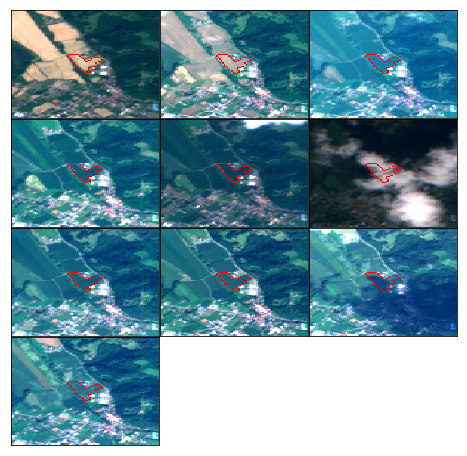

In [5]:
from eolearn.io import S2L1CWCSInput
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
import math

# Normalise the image array for better colour visualisation
def normalize_percentile(image, percentile):
    if (np.percentile(image, 100 - percentile) - np.percentile(image, percentile)) != 0:
        return np.clip((image - np.percentile(image, percentile)) /
                       (np.percentile(image, 100 - percentile) -
                        np.percentile(image, percentile))*255, 0, 255).astype(np.uint8)
    else:
        return np.zeros_like(image)

# Download the images
input_task = S2L1CWCSInput(layer='BANDS-S2-L1C', resx='10m', resy='10m', maxcc=0.2)
example_patch = input_task.execute(example_patch)

# Get the images array
images = example_patch.data['BANDS-S2-L1C'][:,:,:,[3,2,1]]

# Overlay the polygon by rasterising it:
bbox_poly = example_patch.bbox.get_geometry()
geomtrie = example_patch.vector_timeless['polygon']
filtered_data = geomtrie[geomtrie.intersects(bbox_poly)].copy(deep=True)
filtered_data.geometry = filtered_data.geometry.intersection(bbox_poly).exterior
height, width = example_patch.get_spatial_dimension(FeatureType.MASK, 'IS_DATA')
data_transform = rasterio.transform.from_bounds(*example_patch.bbox, width=width, height=height)
raster = np.zeros_like(example_patch.mask['IS_DATA'][0].squeeze()).astype(np.uint8)
rasterio.features.rasterize([(filtered_data.cascaded_union, 255)], out=raster, transform=data_transform, dtype=np.uint8)

# Display all images
fig = plt.figure(figsize=(8, 8))
for i, image in enumerate(images):
    ax = plt.subplot(math.ceil(images.shape[0]/3), 3, i + 1)
    image = normalize_percentile(image, 2)
    # Display the polygon in red
    image[raster==255] = [255, 0, 0]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

We can now run our deep learning model on Sentinel-2 data:

We need to setup a few EO-Task to prepare the data and run the model inference:

In [6]:
# Our model was trained on uint16  data:
class Float32ToUINT16(EOTask):
    def __init__(self, feature):
        self.feature = self._parse_features(feature, new_names=True,
                                            default_feature_type=FeatureType.DATA,
                                            rename_function='{}-UINT16'.format)
    
    def execute(self, eopatch):
        feature_type, feature_name, new_feature_name = next(self.feature(eopatch))
        eopatch[feature_type][new_feature_name] = eopatch[feature_type][feature_name] * 10000
        eopatch[feature_type][new_feature_name] = eopatch[feature_type][new_feature_name].astype(np.uint16)
        return eopatch

# See deep_eval.py for more detail of our implementation
from deep_eval import DeepEval

model_path='/media/data_deep/DATA_H2020_PERSEN/TEST_DATASET/output/trained/CropGroup_small_classes/20190320_1345_unet_unet_relubn__resume_CropGroup_small_classes_softmax_099_crop_sgd/'
cast_task = Float32ToUINT16((FeatureType.DATA, 'BANDS-S2-L1C', 'BANDS-S2-L1C-UINT16'))
eval_task = DeepEval((FeatureType.DATA, 'BANDS-S2-L1C-UINT16', 'MODEL_EVAL'), model_path, gpu_mode=True)

example_patch = cast_task.execute(example_patch)
example_patch = eval_task.execute(example_patch)
display(example_patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(10, 134, 100, 13), dtype=float32)
    BANDS-S2-L1C-UINT16: numpy.ndarray(shape=(10, 134, 100, 13), dtype=uint16)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(10, 134, 100, 1), dtype=bool)
    MODEL_EVAL: numpy.ndarray(shape=(10, 134, 100, 3), dtype=uint8)
    MODEL_EVAL_CLASS: numpy.ndarray(shape=(10, 134, 100, 1), dtype=int64)
    MODEL_EVAL_PROBA: numpy.ndarray(shape=(10, 134, 100, 12), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    class_labels: ['background', ..., 'vineyard'], length=12
    class_rgb: numpy.ndarray(shape=(12, 3), dtype=int64)
    maxcc: 0.2
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.t

We can visualize the output:

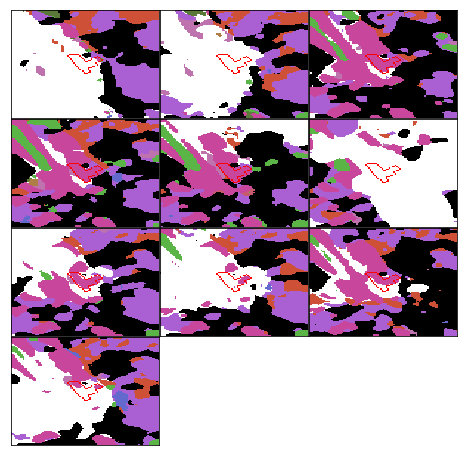

In [7]:
# Get the evaluations
masks = example_patch.mask['MODEL_EVAL']

# Display all evaluations
fig = plt.figure(figsize=(8, 8))
for i, mask in enumerate(masks):
    ax = plt.subplot(math.ceil(masks.shape[0]/3), 3, i + 1)
    # Display the polygon in red
    mask[raster==255] = [255, 0, 0]
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

We can now average all the predictions in a single one to extract the crop type:

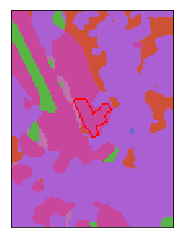

In [8]:
from deep_eval import class_matrix_to_bgr_mask, softmax_to_class_matrix

# We extract the average prediction ignoring background and clouds
class SumPrediction(EOTask):
    def __init__(self, feature, classes_to_ignore=np.asarray([]), threshold=0.5):
        self.feature = self._parse_features(feature, new_names=True,
                                            default_feature_type=FeatureType.DATA,
                                            rename_function='{}_ALL-TIME'.format)
        self.classes_to_ignore = classes_to_ignore
        self.threshold = threshold
        
    def execute(self, eopatch):
        feature_type, feature_name, new_feature_name = next(self.feature(eopatch))
        prediction = eopatch[feature_type][feature_name].sum(axis=0) / len(eopatch.timestamp)
        prediction = softmax_to_class_matrix(prediction,
                                classes_to_ignore=self.classes_to_ignore,
                                threshold=self.threshold)
        prediction = class_matrix_to_bgr_mask(prediction, eopatch.meta_info['class_rgb'], in_place=True)
        eopatch.mask_timeless[new_feature_name] = prediction
        return eopatch

prediction_task = SumPrediction((FeatureType.MASK, 'MODEL_EVAL_PROBA', 'ALL-TIME_PREDICTION'), classes_to_ignore=np.asarray([1]), threshold=0.5)
example_patch = prediction_task.execute(example_patch)

prediction = example_patch.mask_timeless['ALL-TIME_PREDICTION']
prediction[raster==255] = [255, 0, 0]
plt.figure()
plt.imshow(prediction)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.show()

This prediction can now be used to extract the crop type most present inside the polygon and finally get a prediction to compare with the ground truth

In [9]:
from deep_eval import bgr_mask_to_class_matrix

class Rasterize(EOTask):
    def __init__(self, polygon_feature, feature, raster_shape, raster_value):
        self.raster_value = raster_value
        self.raster_shape_type, self.raster_shape_name = raster_shape
        self.feature_type, self.feature_name = feature
        self.polygon_type, self.polygon_name = polygon_feature
        
    def execute(self, eopatch):
        shape = eopatch[self.raster_shape_type][self.raster_shape_name][0,:,:,0].shape
        raster_filled = rasterio.features.rasterize(eopatch[self.polygon_type][self.polygon_name].geometry, out_shape=shape, transform=rasterio.transform.from_bounds(*eopatch.bbox, height=shape[0], width=shape[1]), default_value=self.raster_value)
        eopatch[self.feature_type][self.feature_name] = np.expand_dims(raster_filled, axis=-1)
        return eopatch
    
class ExtractField(EOTask):
    def __init__(self):
        pass
    
    def execute(self, eopatch):
        eval_in_shape = bgr_mask_to_class_matrix(eopatch.mask_timeless['ALL-TIME_PREDICTION'], eopatch.meta_info['class_rgb'])[np.all(eopatch.mask_timeless['CLASS_MASK'] == 255, axis=-1)]
        if len(eval_in_shape) > 0 and (eval_in_shape.shape[0] > 1):
                if eval_in_shape.shape[-1] == 1:
                    eval_in_shape = eval_in_shape.squeeze()
                found = np.unique(eval_in_shape, axis=0, return_counts=True)
                if len(found) == 2 and len(found[0]) > 0 and len(found[1]) > 0:
                    most_present_class = found[0][np.argmax(found[1])]
                    eopatch.label_timeless['LABEL_NUMBER'] = np.array([most_present_class])
                    eopatch.meta_info['FOUND_LABEL'] = [eopatch.meta_info['class_labels'][most_present_class]]
        return eopatch
    
rasterize_gt_task = Rasterize((FeatureType.VECTOR_TIMELESS, 'polygon'), (FeatureType.MASK_TIMELESS, 'CLASS_MASK'), (FeatureType.MASK, 'IS_DATA'), 255)
example_patch = rasterize_gt_task.execute(example_patch)

extract_field_task = ExtractField()
example_patch = extract_field_task.execute(example_patch)
display(example_patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(10, 134, 100, 13), dtype=float32)
    BANDS-S2-L1C-UINT16: numpy.ndarray(shape=(10, 134, 100, 13), dtype=uint16)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(10, 134, 100, 1), dtype=bool)
    MODEL_EVAL: numpy.ndarray(shape=(10, 134, 100, 3), dtype=uint8)
    MODEL_EVAL_CLASS: numpy.ndarray(shape=(10, 134, 100, 1), dtype=int64)
    MODEL_EVAL_PROBA: numpy.ndarray(shape=(10, 134, 100, 12), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL-TIME_PREDICTION: numpy.ndarray(shape=(134, 100, 3), dtype=uint8)
    CLASS_MASK: numpy.ndarray(shape=(134, 100, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {
    LABEL_NUMBER: numpy.ndarray(shape=(1,), dtype=uint8)
  }
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    FOUND_LABEL: ['maize

We can see in the **FOUND_LABEL** field that the predicted crop type is **maize**.

## Visualisation

Finally we can join all thoses tasks inside a workflow to easily use all the previously defined tasks on any polygon:

In [10]:
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(init_task,
                           input_task,
                           cast_task, 
                           eval_task,
                           prediction_task,
                           rasterize_gt_task,
                           extract_field_task) 

polygon = austria_lpis_2016[5:6]
patch = workflow.execute({
            init_task: {'polygon': polygon}
        })
for x in patch.keys():
    patch = patch[x]

We can visualise the results here:

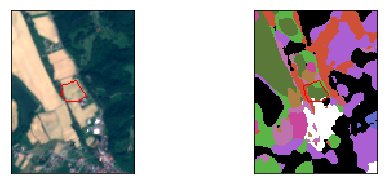

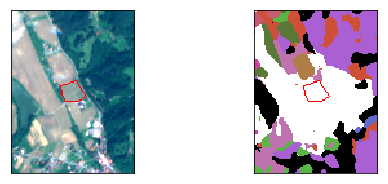

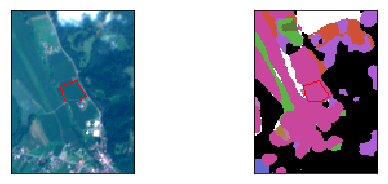

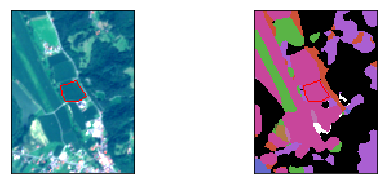

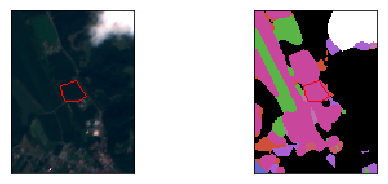

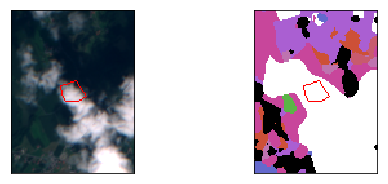

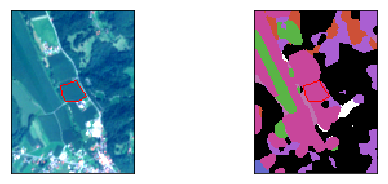

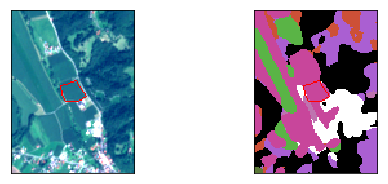

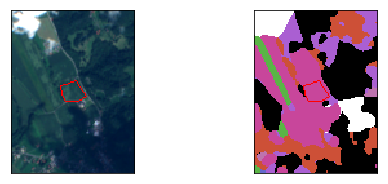

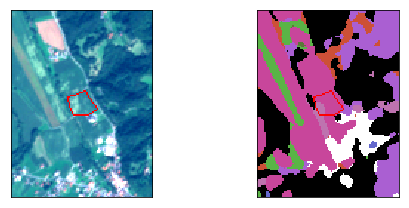

In [11]:
# Overlay the polygon by rasterising it:
bbox_poly = patch.bbox.get_geometry()
geomtrie = patch.vector_timeless['polygon']
filtered_data = geomtrie[geomtrie.intersects(bbox_poly)].copy(deep=True)
filtered_data.geometry = filtered_data.geometry.intersection(bbox_poly).exterior
height, width = patch.get_spatial_dimension(FeatureType.MASK, 'IS_DATA')
data_transform = rasterio.transform.from_bounds(*patch.bbox, width=width, height=height)
raster = np.zeros_like(patch.mask['IS_DATA'][0].squeeze()).astype(np.uint8)
rasterio.features.rasterize([(filtered_data.cascaded_union, 255)], out=raster, transform=data_transform, dtype=np.uint8)

nb_images = patch.data['BANDS-S2-L1C'].shape[0]
for i in range(nb_images):
    plt.figure(figsize=(8,3))
    ax = plt.subplot(1, 2,1)
    image = normalize_percentile(patch.data['BANDS-S2-L1C'][i,:,:,[3,2,1]].transpose((1,2,0)), 2)
    image[raster == 255] = [255, 0, 0]
    ax.imshow(image)
    plt.xticks([])
    plt.yticks([])
#     ax.set_aspect("auto")

    ax = plt.subplot(1, 2, 2)
    mask = patch.mask['MODEL_EVAL'][i]
    mask[raster == 255] = [255, 0, 0]
    ax.imshow(mask)
    plt.xticks([])
    plt.yticks([])
#     ax.set_aspect("auto")
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.show()

And finally:

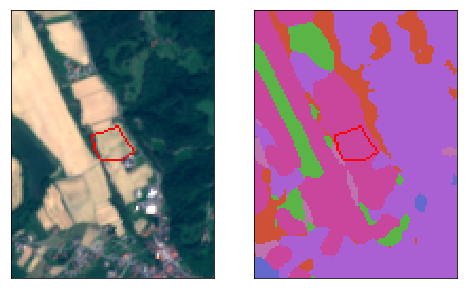

Found crop type : <maize> 


In [12]:
plt.figure(figsize=(8,20))

ax = plt.subplot(1, 2, 1)
image = normalize_percentile(patch.data['BANDS-S2-L1C'][0,:,:,[3,2,1]].transpose((1,2,0)), 2)
image[raster == 255] = [255, 0, 0]
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 2, 2)
mask = patch.mask_timeless['ALL-TIME_PREDICTION']
mask[raster == 255] = [255, 0, 0]
ax.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.show()
print('Found crop type : <%s> '%(patch.meta_info['FOUND_LABEL'][0]))